In [1]:
a = 10
print(a)

10


In [2]:
import juliet
import numpy as np
import matplotlib.pyplot as plt

(1354.1132042490717, 1381.5170629620889)

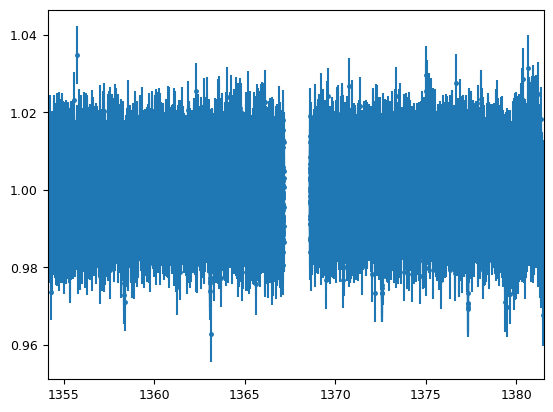

In [3]:
# First, get arrays of times, normalized-fluxes and errors for HATS-46
# from Sector 1 from MAST:
t, f, ferr  = juliet.get_TESS_data('https://archive.stsci.edu/hlsps/'+\
                                   'tess-data-alerts/hlsp_tess-data-'+\
                                   'alerts_tess_phot_00281541555-s02_'+\
                                   'tess_v1_lc.fits')

# Put data arrays into dictionaries so we can fit it with juliet:
times, fluxes, fluxes_error = {},{},{}
times['TESS'], fluxes['TESS'], fluxes_error['TESS'] = t,f,ferr



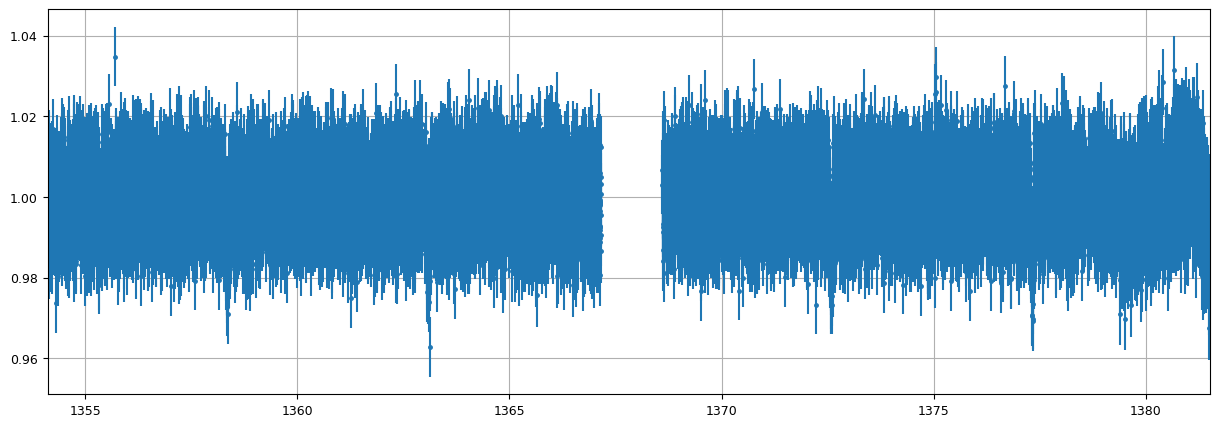

In [9]:
# Plot data:
plt.figure(figsize=(15,5))
plt.errorbar(t, f, yerr=ferr, fmt='.')
plt.xlim([np.min(t),np.max(t)])
plt.grid('on')
plt.show()

In [10]:
priors = {}

# Name of the parameters to be fit:
params = ['P_p1','t0_p1','r1_p1','r2_p1','q1_TESS','q2_TESS','ecc_p1','omega_p1',\
              'rho', 'mdilution_TESS', 'mflux_TESS', 'sigma_w_TESS']

# Distributions:
dists = ['normal','normal','uniform','uniform','uniform','uniform','fixed','fixed',\
                 'loguniform', 'fixed', 'normal', 'loguniform']

# Hyperparameters
hyperps = [[4.7,0.1], [1358.4,0.1], [0.,1], [0.,1.], [0., 1.], [0., 1.], 0.0, 90.,\
                   [100., 10000.], 1.0, [0.,0.1], [0.1, 1000.]]

# Populate the priors dictionary:
for param, dist, hyperp in zip(params, dists, hyperps):
    priors[param] = {}
    priors[param]['distribution'], priors[param]['hyperparameters'] = dist, hyperp


In [11]:
# Load and fit dataset with juliet:
dataset = juliet.load(priors=priors, t_lc = times, y_lc = fluxes, \
                   yerr_lc = fluxes_error, out_folder = 'hats46')

results = dataset.fit()

PyMultinest installation not detected. Forcing dynesty as the sampler.


14710it [18:06, 13.54it/s, +500 | bound: 174 | nc: 1 | ncall: 393122 | eff(%):  3.874 | loglstar:   -inf < 64230.985 <    inf | logz: 64202.169 +/-  0.242 | dlogz:  0.001 >  0.509]


(0.98, 1.02)

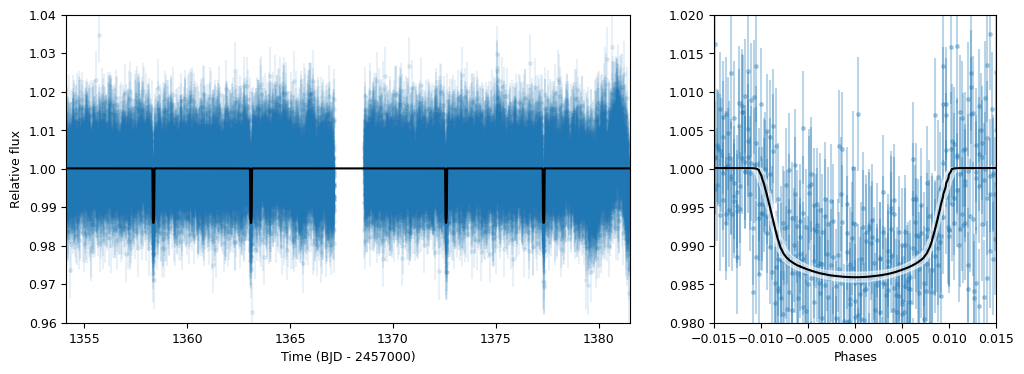

In [12]:
# Extract median model and the ones that cover the 68% credibility band around it:
transit_model, transit_up68, transit_low68  = results.lc.evaluate('TESS', return_err=True)

# To plot the phased lighcurve we need the median period and time-of-transit center:
P, t0 = np.median(results.posteriors['posterior_samples']['P_p1']),\
        np.median(results.posteriors['posterior_samples']['t0_p1'])

# Get phases:
phases = juliet.get_phases(dataset.times_lc['TESS'], P, t0)


import matplotlib.gridspec as gridspec

# Plot the data. First, time versus flux --- plot only the median model here:
fig = plt.figure(figsize=(12,4))
gs = gridspec.GridSpec(1, 2, width_ratios=[2,1])
ax1 = plt.subplot(gs[0])

ax1.errorbar(dataset.times_lc['TESS'], dataset.data_lc['TESS'], \
             yerr = dataset.errors_lc['TESS'], fmt = '.' , alpha = 0.1)

# Plot the median model:
ax1.plot(dataset.times_lc['TESS'], transit_model, color='black',zorder=10)

# Plot portion of the lightcurve, axes, etc.:
ax1.set_xlim([np.min(dataset.times_lc['TESS']),np.max(dataset.times_lc['TESS'])])
ax1.set_ylim([0.96,1.04])
ax1.set_xlabel('Time (BJD - 2457000)')
ax1.set_ylabel('Relative flux')

# Now plot phased model; plot the error band of the best-fit model here:
ax2 = plt.subplot(gs[1])
ax2.errorbar(phases, dataset.data_lc['TESS'], \
             yerr = dataset.errors_lc['TESS'], fmt = '.', alpha = 0.3)
idx = np.argsort(phases)
ax2.plot(phases[idx],transit_model[idx], color='black',zorder=10)
ax2.fill_between(phases[idx],transit_up68[idx],transit_low68[idx],\
                 color='white',alpha=0.5,zorder=5)
ax2.set_xlabel('Phases')
ax2.set_xlim([-0.015,0.015])
ax2.set_ylim([0.98,1.02])

Text(0, 0.5, '$p = R_p/R_*$')

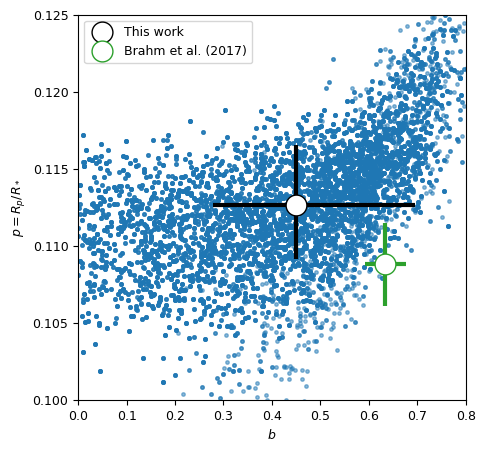

In [30]:
fig = plt.figure(figsize=(5,5))
# Store posterior samples for r1 and r2:
r1, r2 = results.posteriors['posterior_samples']['r1_p1'],\
         results.posteriors['posterior_samples']['r2_p1']

# Transform back to (b,p):
b,p = juliet.utils.reverse_bp(r1, r2, 0., 1.)

# Plot posterior distribution:
plt.plot(b,p,'.',alpha=0.5)

# Extract median and 1-sigma errors for b and p from
# the posterior distribution:
bm,bu,bl = juliet.utils.get_quantiles(b)
pm,pu,pl = juliet.utils.get_quantiles(p)

# Plot them:
plt.errorbar(np.array([bm]),np.array([pm]),
             xerr = np.array([bu-bm,bm-bl]).reshape((2, 1)),
             yerr = np.array([pu-pm,pm-pl]).reshape((2, 1)),
             fmt = 'o', mfc = 'white', mec = 'black',
             ecolor='black', ms = 15, elinewidth = 3,zorder = 5, label = 'This work')

# Plot values in Brahm et al. (2017):
plt.errorbar(np.array([0.634]),np.array([0.1088]),\
             xerr = np.array([0.042]), \
             yerr = np.array([0.0027]),zorder = 5,\
             label = 'Brahm et al. (2017)', fmt='o', \
             mfc = 'white', elinewidth = 3, ms = 15)

plt.legend()
plt.xlim([0.,0.8])
plt.ylim([0.1,0.125])
plt.xlabel('$b$')
plt.ylabel('$p = R_p/R_*$')

(-0.5, 1.0)

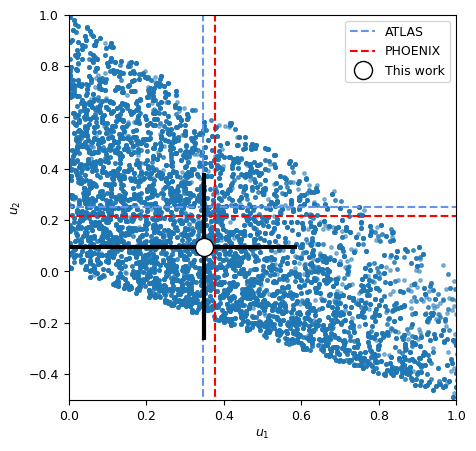

In [28]:
fig = plt.figure(figsize=(5,5))
# Store posterior samples for q1 and q2:
q1, q2 = results.posteriors['posterior_samples']['q1_TESS'],\
          results.posteriors['posterior_samples']['q2_TESS']

# Transform back to (u1,u2):
u1, u2 = juliet.utils.reverse_ld_coeffs('quadratic', q1, q2)

# Plot posterior distribution:
plt.plot(u1,u2,'.',alpha=0.5)

# Plot medians and errors implied by the posterior:
u1m,u1u,u1l = juliet.utils.get_quantiles(u1)
u2m,u2u,u2l = juliet.utils.get_quantiles(u2)
plt.errorbar(np.array([u1m]),np.array([u2m]),\
             xerr = np.array([u1u-u1m,u1m-u1l]).reshape((2, 1)),\
             yerr = np.array([u2u-u2m,u2m-u2l]).reshape((2, 1)),\
             fmt = 'o', mfc = 'white', mec = 'black',\
             ecolor='black', ms = 13, elinewidth = 3, \
             zorder = 5, label = 'This work')

plt.plot(np.array([0.346,0.346]),np.array([-1,1]),'--',color='cornflowerblue')
plt.plot(np.array([-1,1]),np.array([0.251,0.251]),'--',color='cornflowerblue',label='ATLAS')

plt.plot(np.array([0.377,0.377]),np.array([-1,1]),'--',color='red')
plt.plot(np.array([-1,1]),np.array([0.214,0.214]),'--',color='red',label='PHOENIX')
plt.legend()

plt.xlabel('$u_1$')
plt.ylabel('$u_2$')
plt.xlim([0.0,1.0])
plt.ylim([-0.5,1.0])

In [31]:
print('u1m = ',u1m)
print('u2m = ',u2m)


u1m =  0.34866667842632526
u2m =  0.09490527472849555
